In [1]:
import numpy as np
import pandas as pd
import os
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.ticker as mtick
import seaborn as sns
from statsmodels.tsa.ardl import ardl_select_order
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import kpss, adfuller
warnings.filterwarnings('ignore')


In [2]:
directories = "/Users/Marta/Desktop/diploma/google trends/"

In [34]:
google_trends_df = pd.DataFrame(index=pd.date_range(start='2012-01-01', end='2024-12-01', freq="MS"))
aggregated_google_trends = pd.DataFrame(index=pd.date_range(start='2012-01-01', end='2024-12-01', freq="MS"))

In [35]:
for dir_ in os.listdir(directories):
    d2_path = os.path.join(directories, dir_)
    if dir_ == ".DS_Store":
        continue
    for f_ in os.listdir(d2_path):
        if f_ == ".DS_Store":
            continue
        if os.path.isfile(d2_path+"/"+f_):
#             print(d2_path+"/"+f_)
            c = f_.replace(".csv", "") +"-"+ dir_
            df_file = pd.read_csv(d2_path+"/"+f_, sep=",", skiprows=2)
            df_file.columns = ["Week", c]
            df_file["Month"] = df_file["Week"].apply(lambda x: pd.datetime(pd.to_datetime(x).year, pd.to_datetime(x).month, 1))
            df_file = df_file.groupby("Month")[c].sum().reset_index()
            df_file.set_index("Month", inplace=True)
            google_trends_df = pd.concat([google_trends_df, df_file[c]], axis=1)          
            

In [36]:
#anonymus customer pains
terms = ...


# terms2 = ["customer_pain1", "customer_pain2", "customer_pain3", "customer_pain4", "customer_pain5", "customer_pain1"]
for term in terms:
    aggregated_google_trends[term] = google_trends_df.filter(like=term, axis=1).mean(axis=1)


In [37]:
gdp_per_capita = pd.read_csv("/Users/Marta/Desktop/diploma/exog/ukraine-gdp-per-capita.csv")
gdp_per_capita.columns = ["date", "GDP", "Rate", ""]
population = pd.read_csv("/Users/Marta/Desktop/diploma/exog/ukraine-population.csv")
population.columns = ["date", "Population", "Rate"]
df_uah1 = pd.read_excel("/Users/Marta/Desktop/diploma/Data_1_S.xlsx", "quantity")
prices = pd.read_excel("/Users/Marta/Desktop/diploma/Data_1_S.xlsx", "price_uah")
prices = prices.set_index("Period")
prices.columns = [c+"_price" for c in prices.columns]
prices = prices.fillna(0)
totals = pd.read_excel("/Users/Marta/Desktop/diploma/Data_1_S.xlsx", "totals")
totals

,Period,Total demand,Total revenue,Average price
0,2012-01-01,2.272786e+08,1.105502e+08,0.486408
1,2012-02-01,2.188441e+08,1.078382e+08,0.492763
2,2012-03-01,2.483203e+08,1.221922e+08,0.492075
3,2012-04-01,2.362335e+08,1.196472e+08,0.506479
4,2012-05-01,2.396643e+08,1.219699e+08,0.508920
...,...,...,...,...
127,2022-08-01,2.180656e+08,6.677227e+08,3.062027
128,2022-09-01,2.128312e+08,7.265821e+08,3.413890
129,2022-10-01,2.005121e+08,7.244215e+08,3.612857
130,2022-11-01,1.937368e+08,7.045184e+08,3.636472


In [38]:
internet_accessability = pd.read_csv("/Users/Marta/Desktop/diploma/exog/internet_accessability.csv", skiprows=4)
# population.columns = ["date", "Population", "Rate"]

internet_accessability = internet_accessability[internet_accessability["Country Name"]=="Ukraine"].T.iloc[4:66]
internet_accessability["date"] = pd.date_range(start='1960-01-01', end='2022-06-01', freq="Y")
projections = pd.read_excel("/Users/Marta/Desktop/diploma/exog/Macroeconomic_Forecast_table_2023_01_en.xlsx", "projections")

def agg_by_month(df, col="GDP"):
    df_final = pd.DataFrame(index=df_uah1["Period"].apply(lambda x: pd.datetime(pd.to_datetime(x).year, pd.to_datetime(x).month, 1)))
    df_final["Year"] = df_final.index
    df_final["Year"] = df_final["Year"].apply(lambda x: pd.to_datetime(x).year)
    df_final["Month"] = df_final.index
    df["Year"] = df["date"].apply(lambda x: pd.to_datetime(x).year)
    df = pd.merge(df_final, df, how="left", left_on="Year", right_on="Year")
    df = df[["Month", col]]
    
    if col == "Population":
        v = df[col].iloc[119]
        v -= 4000000
        df[col] = df[col].fillna( v )

    else:
        df[col] = df[col].fillna(df[col].iloc[119])
    return df


aggregated_gdp_per_capita = agg_by_month(gdp_per_capita).set_index("Month")
aggregated_population = agg_by_month(population, "Population").set_index("Month")
aggregated_internet_accessability = agg_by_month(internet_accessability, 248).set_index("Month")
aggregated_internet_accessability.columns = ["Internet_access"]
aggregated_internet_accessability = aggregated_internet_accessability.fillna(75.037909)

cpi = pd.read_excel("/Users/Marta/Desktop/diploma/exog/CCPI_m.xlsx", "Sheet2")
t__ = cpi.iloc[5, :].T
cpis = pd.DataFrame(index=pd.date_range(start='2012-01-01', end='2023-03-01', freq="MS"))
cpis["CPI"] = t__

exogenous = pd.concat([
    aggregated_google_trends, 
                       df_uah1.set_index("Period"), 
                       prices
                       ,
                       aggregated_internet_accessability,
                      aggregated_population, aggregated_gdp_per_capita, cpis
                      ], axis=1).dropna()


In [40]:
aggregated_google_trends.columns = ["customer_pain1", "customer_pain2", "customer_pain3", "customer_pain4", "customer_pain5", "customer_pain1"]

<Axes: >

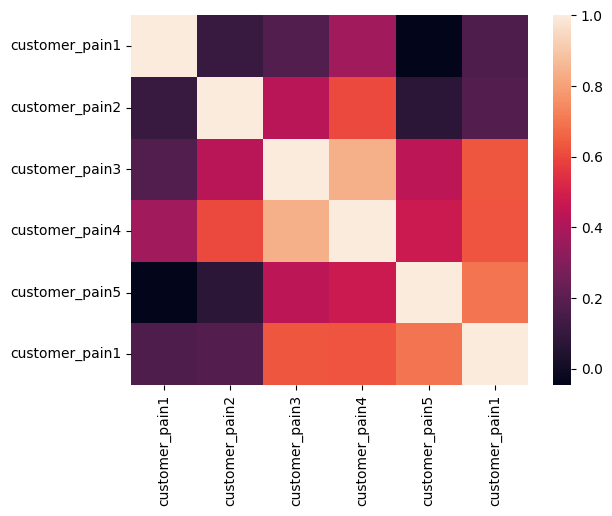

In [41]:
sns.heatmap(aggregated_google_trends.corr())

In [47]:
final = df_uah1[["T1", "T2", "T3", "T4", "Total 2"]]
final["Total 3"] = df_uah1[["T1", "T2", "T3", "T4", "Total 2"]].sum(axis=1)
# final
for i in ["T1", "T2", "T3", "T4", "Total 2"]:
    final[f"{i}_percentage"] = final[i]*100/final["Total 3"]
    
    
for c in exogenous[[c for c in exogenous.columns if ("price" in c and "T" in c) ]].columns:
#     print(exogenous.loc[:,c])
#     print(exogenous.loc[:,"CPI"])
    final[f"{c}_CPI"] = list(exogenous.loc[:,c]/(exogenous.loc[:, "CPI"]))
    final[f"{c}"] = list(exogenous.loc[:,c])
    
#     .replace(0.0, np.nan)
# final

In [2]:
for i in ["T1", "T2", "T3", "T4", "Total 2"]:
    final[f"{i}_price_component"] = np.dot(final[[c in c if "Total 1" not in c and "price" in c]])
    m = OLS(np.asarray(final[f"{i}_percentage"]),np.asarray(final[f"{i}_price_CPI"]/))
    results = m.fit()
    results.summary()

In [1]:
final[f"T2_price_component"] = final["T1_price_CPI"]*final["T1"]/(final["Total 3"] - final["T2"]) +\
                                final["T3_price_CPI"]*final["T3"]/(final["Total 3"] - final["T2"]) +\
                                final["T4_price_CPI"]*final["T4"]/(final["Total 3"] - final["T2"]) +\
                                final["Total 2_price_CPI"]*final["Total 2"]/(final["Total 3"] - final["T2"])

final[f"T1_price_component"] = final["T2_price_CPI"]*final["T2"]/(final["Total 3"] - final["T1"]) +\
                                final["T3_price_CPI"]*final["T3"]/(final["Total 3"] - final["T1"]) +\
                                final["T4_price_CPI"]*final["T4"]/(final["Total 3"] - final["T1"]) +\
                                final["Total 2_price_CPI"]*final["Total 2"]/(final["Total 3"] - final["T1"])

final[f"T3_price_component"] = final["T2_price_CPI"]*final["T2"]/(final["Total 3"] - final["T3"]) +\
                                final["T1_price_CPI"]*final["T1"]/(final["Total 3"] - final["T3"]) +\
                                final["T4_price_CPI"]*final["T4"]/(final["Total 3"] - final["T3"]) +\
                                final["Total 2_price_CPI"]*final["Total 2"]/(final["Total 3"] - final["T3"])

final[f"T4_price_component"] = final["T2_price_CPI"]*final["T2"]/(final["Total 3"] - final["T4"]) +\
                                final["T1_price_CPI"]*final["T1"]/(final["Total 3"] - final["T4"]) +\
                                final["T3_price_CPI"]*final["T3"]/(final["Total 3"] - final["T4"]) +\
                                final["Total 2_price_CPI"]*final["Total 2"]/(final["Total 3"] - final["T4"])

final[f"Total 2_price_component"] = final["T2_price_CPI"]*final["T2"]/(final["Total 3"] - final["Total 2"]) +\
                                final["T1_price_CPI"]*final["T1"]/(final["Total 3"] - final["Total 2"]) +\
                                final["T3_price_CPI"]*final["T3"]/(final["Total 3"] - final["Total 2"]) +\
                                final["T4_price_CPI"]*final["T4"]/(final["Total 3"] - final["Total 2"])

# final[f"T2_price_component"]
x_arr = sm.add_constant(np.asarray(final[f"T1_price"]/final[f"T1_price_component"]))
# x_arr = np.asarray(final[f"T1_price_CPI"]/final[f"T2_price_component"])


m = OLS(np.asarray(final[f"T1_percentage"]),x_arr)
results = m.fit()
results.summary()

In [50]:

fig,ax = plt.subplots(5, figsize=(10, 10),sharex=True,)
sp = 0

for spine in plt.gca().spines.values():
    if sp in [1, 3]:
        spine.set_visible(False)
    sp += 1

j = 0
for i in ["T2", "Total 2", "T3", "T1", "T4"]:
    x=np.asarray(final[f"{i}_price"]/final[f"{i}_price_component"])
    ax[j].scatter(x,final[f"{i}_percentage"], label="Market share")
    z = np.polyfit(x,final[f"{i}_percentage"], 1)
    p = np.poly1d(z)
    print(z)
    ax[j].plot(x, p(x), color="black")
    ax[j].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

    j += 1
plt.title("Market share relatioship to price")


In [ ]:
fig,ax = plt.subplots(1, figsize=(10, 8))
sp = 0
for spine in plt.gca().spines.values():
    if sp in [1, 3]:
        spine.set_visible(False)
    sp += 1
df_prices_total = totals[["Average price", "Total demand"]]
df_prices_total["CPI"] = list(cpis["CPI"])[:132]
additive_decomposition = seasonal_decompose(x=df_prices_total["Total demand"], model='additive', period=12)
df_prices_total["Deseasonalized demand"] = additive_decomposition.trend + additive_decomposition.resid
df_prices_total["Deseasonalized demand"] = df_prices_total["Deseasonalized demand"].fillna(df_prices_total["Deseasonalized demand"].mean())
df_prices_total["price_CPI"] = df_prices_total["Average price"]/df_prices_total["CPI"]
df_prices_total= df_prices_total.sort_values(by="price_CPI", ascending=False)


ax.scatter(x,df_prices_total["Total demand"], label="Total demand")
z = np.polyfit(x,df_prices_total["Total demand"], 1)
p = np.poly1d(z)

plt.plot(x, p(x), color="black")
plt.xlabel("Price, adjusted for CPI")
plt.ylabel("Units sold")



In [ ]:

fig,ax = plt.subplots(2,2, figsize=(8, 8),sharex=True,)
sp = 0

j = 0
for i in ["Internet_access", "Population", "GDP", "CPI"]:
    z = np.polyfit(list(range(len(projections.index))),list(projections[i]), 20)
    
    p = np.poly1d(z)
    projections[f"{i}_smoothed_predicted"] = p(list(range(len(projections.index))))
    ax[j//2, j - j//2-1].plot(projections.index,p(list(range(len(projections.index)))), label="Market share")
    ax[j//2, j - j//2-1].set_title(i)
#     print(z)
    j += 1

In [ ]:


def check_stationarity(ts):
#     dftest = adfuller(ts.diff().diff().diff().dropna(),regression="ct")
    dftest = adfuller(ts.diff().dropna())
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    print(dftest)
    if (pvalue < 0.1) and (adf < critical_value):
        print('The series is stationary')
        print(round(dftest[1], 3))
    else:
        print('The series is NOT stationary')
        print(round(dftest[1], 3))
    print("\n")

check_stationarity(exogenous["GDP"])
check_stationarity(exogenous["Population"])
check_stationarity(exogenous["Internet_access"])
check_stationarity(exogenous["CPI"])
check_stationarity(exogenous["customer_pain1"])
check_stationarity(exogenous["customer_pain2"])
check_stationarity(exogenous["customer_pain3"])
check_stationarity(exogenous["customer_pain4"])
check_stationarity(exogenous["customer_pain5"])
check_stationarity(exogenous["customer_pain6"])
print("\n\n\n")


In [ ]:

pains_predicted = pd.DataFrame(index=preds.index)
d_pains = {
           "customer_pain1": [(1,1,0,0,1),1, 1, "ct", "additive"],
           "customer_pain2": [(1,1),1, (1,1), "c", "additive"],
           "customer_pain3": [(0,0,0,1,1),1, 0, "c", "additive"],
           "customer_pain4": [(1,1), 1, (0,1,1), "c", "multiplicative"],
           "customer_pain5": [(1,1),1,(1,0,1,1), "c", "additive"],
           "customer_pain6": [(0,0,0,0,1,1,0,1),1, 0, "c", "additive"],
          }
for i in d_pains:
    m = SARIMAX(exogenous[i], 
                order=(d_pains[i][0],d_pains[i][1],d_pains[i][2]), 
                seasonal_order=(d_pains[i][0],d_pains[i][1],d_pains[i][2],12), 
                type="additive", 
                trend=d_pains[i][3]).fit()

    preds = m.predict(start = 0, end= len(exogenous[i]) + 24, dynamic=False)
    
    preds[0] =preds[1]
    preds.plot()
    exogenous[i].plot()
    plt.show()
    pains_predicted[i]= preds
    print(preds)
    

In [ ]:
pains_predicted.clip(lower=0).to_csv("/Users/Marta/Desktop/diploma/exog/customer_pain_predicted.csv")

In [ ]:
def check_kpss(ts):
    dftest = kpss(ts, regression="c")
#     dftest = kpss(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[3]['10%']
    print(dftest)

    if (pvalue < 0.1) and (adf < critical_value):
        print(pvalue, adf)
        print('The series is not stationary')
        print(round(dftest[1], 3))
        
    else:
        print('The series is stationary')
        print(round(dftest[1], 3))
    print("\n")
check_kpss(exogenous["GDP"])
check_kpss(exogenous["Population"])
check_kpss(exogenous["Internet_access"])
check_kpss(exogenous["CPI"])
check_kpss(exogenous["customer_pain1"])
check_kpss(exogenous["customer_pain2"])
check_kpss(exogenous["customer_pain3"])
check_kpss(exogenous["customer_pain4"])
check_kpss(exogenous["customer_pain5"])
check_kpss(exogenous["customer_pain6"])
check_kpss(exogenous["Average_price"].dropna())
print("\n\n\n")

In [ ]:

v = 4

additive_decomposition = seasonal_decompose(x=exogenous[f"customer_pain{str(v)}"].dropna(), model='additive', period=12)
additive_estimated_trend = additive_decomposition.trend
additive_estimated_seasonal = additive_decomposition.seasonal
additive_estimated_residual = additive_decomposition.resid

fig, axes = plt.subplots(1,2, figsize=(15, 4), sharex=True)

fig = plot_pacf(additive_estimated_residual.dropna(), lags=50, ax=axes[0])
fig = plot_acf(additive_estimated_residual.dropna(), lags=50, ax=axes[1])
axes[0].set_xlabel('Lags')
axes[1].set_xlabel('Lags')


In [ ]:
projections.to_csv("/Users/Marta/Desktop/diploma/exog/x_projections.csv")

<Axes: title={'center': "Correlation between competitor \n products' demand"}>

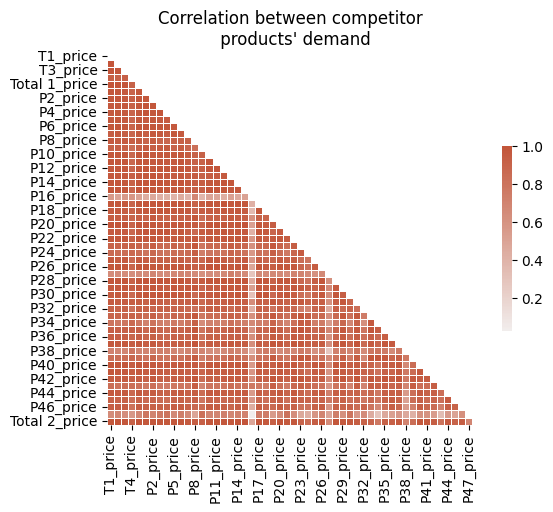

In [25]:
# exogenous.to_csv("/Users/Marta/Desktop/diploma/exogenous_with_prices.csv")
# exogenous[[c for c in exogenous.columns if "price" in c]].corr()

# from statsmodels.tsa.ardl import ardl_select_order
corr = exogenous[[c for c in exogenous.columns if "price" in c]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 6))
plt.title("Correlation between competitor \n products' demand")

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .4})


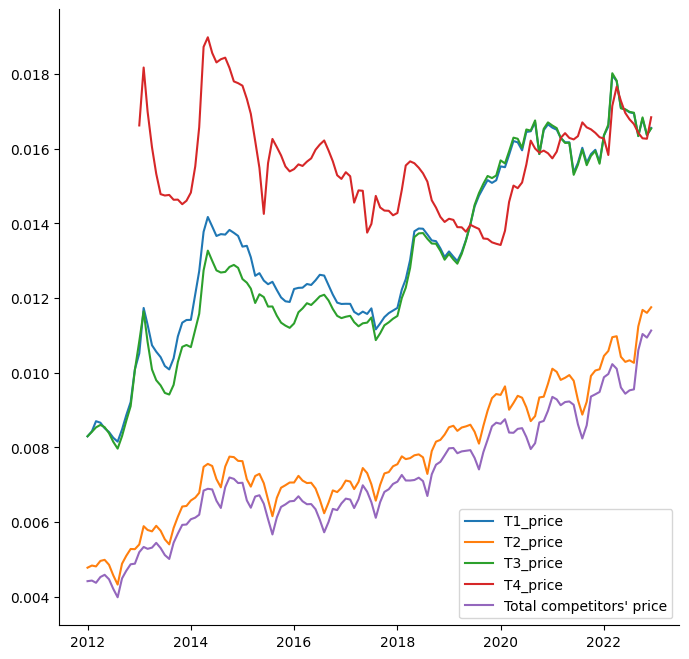

In [26]:
# exogenous[[c for c in exogenous.columns if ("price" in c and "T" in c) ]].plot()
# exogenous[['T1_price', 'T2_price', 'T3_price', 'T4_price', 'Total 2_price']].plot()
# exogenous.columns

f = plt.figure(figsize=(8, 8))
sp = 0
for spine in plt.gca().spines.values():
    if sp in [1, 3]:
        spine.set_visible(False)
    sp += 1
for c in exogenous[[c for c in exogenous.columns if ("price" in c and "T" in c) ]].columns:
#     exogenous[f"{c}_CPI"] = exogenous[c]/exogenous["CPI"]
    if c == "T4_price":
        plt.plot(exogenous.loc["2013-01-01":, c]/exogenous.loc["2013-01-01":,"CPI"].replace(0.0, np.nan), label=f"{c}")
    elif  c == "Total 1_price":
        continue
    elif  c == "Total 2_price":
        plt.plot(exogenous[c]/exogenous["CPI"].replace(0.0, np.nan), label="Total competitors' price")
    else:
        plt.plot(exogenous[c]/exogenous["CPI"].replace(0.0, np.nan), label=f"{c}")



# plt.plot(exogenous[[c for c in exogenous.columns if ("price_CPI" in c and "T" in c) ]].replace(0, np.nan), )
plt.legend()

In [ ]:
for col in exogenous.columns:
    try:
        x_s = exogenous[[c for c in exogenous.columns if c != col and "Total" not in c and "P" not in c]]
        print(x_s)
        y = exogenous["T1"]
        print(y)
    #     print(x_s , y)

        sel_res = ardl_select_order(y, 3, x_s, 3, ic="aic", trend="c"
        )
        print(f"The optimal order for {col} is: {sel_res.model.ardl_order}")
    except Exception as e:
        print(f"there was an exception:{e}")


In [ ]:
print(exogenous.columns)

cols_ = ['customer_pain1',
 'customer_pain2',
 'customer_pain3',
 'customer_pain4',
 'customer_pain5',
 'customer_pain6',
 'Internet_access',
 'Population',
 'GDP',
 'CPI',
 'Total_1_price',
 'Total_2_price']

In [ ]:
corr = exogenous[cols_].fillna(100.0).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .4})

In [ ]:
from statsmodels.regression.linear_model import OLS
from linearmodels.iv.model import IV2SLS 
import statsmodels as sm

new_cols = ['customer_pain2', 'customer_pain4', 'Population', 'GDP', 'CPI', 'Total_2_price', 'Total_1_price']
m = OLS(np.asarray(exogenous["T1"].fillna(0)),np.asarray(exogenous[new_cols].fillna(0)))
results = m.fit()
results.summary()

In [ ]:
# IV2SLS

m = IV2SLS(exogenous["T1"], exogenous[["Population", "GDP", "Total_1_price"]], exogenous[["customer_pain2", "Total_2_price"]], exogenous[["Internet_access", "CPI"]]).fit()
formula = 'T1 ~ 1 + C(Population) + C(GDP) + C(CPI) + C(Total_2_price) + [customer_pain2 ~ Internet_access]'
iv_many_zs = sm.sandbox.regression.gmm.IV2SLS.from_formula(formula, exogenous).fit()
parse(iv_many_zs)


In [ ]:
# exogenous[["customer_pain1", "Internet_access"]].corr()
exogenous.to_csv("/Users/Marta/Desktop/diploma/exog/exogenous_dataframe.csv")

In [ ]:
# exogenous["Total_3"] = exogenous["Total_1"] + exogenous["Total_2"]
exogenous["Total_3"] = list(totals["Total demand"])
exogenous["Average_price"] = list(totals["Average price"])

In [ ]:
cols2 = ['customer_pain1',
 'customer_pain2',
 'customer_pain3',
 'customer_pain4',
 'customer_pain5',
 'customer_pain6',
 'Internet_access',
 'Population',
 'GDP',
 'CPI',
'Average_price',
'Total_3'
]

In [ ]:
# Johansen test
import statsmodels.api as sm
import statsmodels
johansen_test = statsmodels.tsa.vector_ar.vecm.coint_johansen(exogenous[cols_].fillna(100.0), det_order=1, k_ar_diff=1)

print(johansen_test.trace_stat)
print("\n\n")
print(johansen_test.trace_stat_crit_vals)

johansen_test

